# Product Recommendation Full Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use("ggplot")

import sklearn
from sklearn.decomposition import TruncatedSVD

#### Importing the datasets

**ky** - Kenya

**ng** - Nigeria

In [2]:
missing_value_formats = "-"
ky_customers = pd.read_csv('./datasets/Kenya Customers.csv', na_values = missing_value_formats)

In [3]:
missing_value_formats = "-"
ky_deliveries = pd.read_csv('./datasets/Kenya Deliveries.csv', na_values = missing_value_formats)

missing_value_formats = "-"
ky_orders = pd.read_csv('./datasets/Kenya Orders.csv', na_values = missing_value_formats)

missing_value_formats = "-"
ng_customers = pd.read_csv('./datasets/Nigeria Customers.csv', na_values = missing_value_formats)

missing_value_formats = "-"
ng_deliveries = pd.read_csv('./datasets/Nigeria Deliveries.csv', na_values = missing_value_formats)

missing_value_formats = "-"
ng_orders = pd.read_csv('./datasets/Nigeria Orders.csv', na_values = missing_value_formats)

#### Merging datasets for Kenya

In [4]:
ky_data = pd.concat([ky_customers, ky_orders], axis=1)

In [5]:
ky_data = pd.concat([ky_data, ky_deliveries], axis=1)

#### Merging datasets for Nigeria

In [6]:
ng_data = pd.concat([ng_customers, ng_orders], axis=1)

In [7]:
ng_data = pd.concat([ng_data, ng_deliveries], axis=1)

#### Data Cleaning Kenya

In [8]:
ky_orders.dropna(axis = 1, how ='all', inplace=True)

In [9]:
ky_orders['Description'].fillna('None', inplace=True)

In [10]:
ky_orders['SKU'].fillna('None', inplace=True)

In [11]:
ky_orders['Ratings'].fillna(0, inplace=True)

In [12]:
ky_orders['Reviews'].fillna('No review', inplace=True)

In [13]:
ky_orders['Redeemed Loyalty Points'].fillna(0, inplace=True)

In [14]:
ky_orders['Consumed Loyalty Points'].fillna(0, inplace=True)

In [15]:
ky_orders['Cost Price'].fillna(method='pad', inplace=True)
ky_orders['Total Cost Price'].fillna(method='pad', inplace=True)
ky_orders['Category Name'].fillna(method='pad', inplace=True)

In [16]:
ky_orders.isnull().sum()

Order ID                   0
Order Status               0
Category Name              0
SKU                        0
Quantity                   0
Unit Price                 0
Cost Price                 0
Total Cost Price           0
Total Price                0
Order Total                0
Sub Total                  0
Remaining Balance          0
Payment Method             0
Transaction ID             0
Currency Symbol            0
Customer ID                0
Merchant ID                0
Store Name                 0
Pickup Address             0
Description                0
Distance (in km)           0
Order Time                 0
Pickup Time                0
Delivery Time              0
Ratings                    0
Reviews                    0
Order Preparation Time     0
Redeemed Loyalty Points    0
Consumed Loyalty Points    0
Flat Discount              0
dtype: int64

## Product Recommendation

A well developed recommendation system will help businesses improve their customers experience on website and result in better customer acquisition and retention.

The recommendation system, I have designed below is based on the journey of a new customer from the time he/she lands on the business’s website for the first time to when he/she makes repeat purchases.

The recommendation system is designed in 3 parts based on the business context:

* Recommendation system part I: Product popularity based system targetted at new customers

* Recommendation system part II: Model-based collaborative filtering system based on customer's purchase history and ratings provided by other users who bought items similar items

* Recommendation system part III: When a business is setting up its e-commerce website for the first time without any product rating

When a new customer without any previous purchase history visits the e-commerce website for the first time, he/she is recommended the most popular products sold on the company's website. Once, he/she makes a purchase, the recommendation system updates and recommends other products based on the purchase history and ratings provided by other users on the website. The latter part is done using collaborative filtering techniques.


##### Recommendation System - Part I
Product popularity based recommendation system targeted at new customers
* Popularity based are a great strategy to target the new customers with the most popular products sold on a business's website and is very useful to cold start a recommendation engine.

In [17]:
popular_products = pd.DataFrame(ky_orders.groupby('Order ID')['Ratings'].count())
most_popular = popular_products.sort_values('Ratings', ascending=False)
most_popular.head(10)

,Ratings
Order ID,
11197785,36
11118329,34
10806900,33
10642619,33
10942771,31
10879490,30
11157008,30
10807207,28
11253143,28


<AxesSubplot:xlabel='Order ID'>

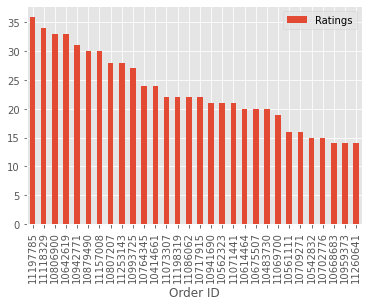

In [18]:
most_popular.head(30).plot(kind = "bar")

**Analysis:**

The above graph gives us the most popular products (arranged in descending order) sold by the business.

#### Recommendation System - Part II
Model-based collaborative filtering system

* Recommend items to users based on purchase history and similarity of ratings provided by other users who bought items to that of a particular customer.
* A model based collaborative filtering technique is chosen here as it helps in making predicting products for a particular user by identifying patterns based on preferences from multiple user data.

Utility Matrix based on products sold and user reviews


**Utility Matrix :** An utlity matrix is consists of all possible user-item preferences (ratings) details represented as a matrix. The utility matrix is sparce as none of the users would buy all the items in the list, hence, most of the values are unknown.

In [19]:
# Subset of Dataset

sub_ky_orders = ky_orders.head(10000)

In [20]:
sub_ky_orders['Ratings'] = sub_ky_orders['Ratings'].astype('int')

<ipython-input-20-43cf981ff5e4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_ky_orders['Ratings'] = sub_ky_orders['Ratings'].astype('int')


In [21]:
sub_ky_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Order ID                 10000 non-null  int64  
 1   Order Status             10000 non-null  object 
 2   Category Name            10000 non-null  object 
 3   SKU                      10000 non-null  object 
 4   Quantity                 10000 non-null  int64  
 5   Unit Price               10000 non-null  int64  
 6   Cost Price               10000 non-null  float64
 7   Total Cost Price         10000 non-null  float64
 8   Total Price              10000 non-null  int64  
 9   Order Total              10000 non-null  float64
 10  Sub Total                10000 non-null  int64  
 11  Remaining Balance        10000 non-null  int64  
 12  Payment Method           10000 non-null  object 
 13  Transaction ID           10000 non-null  int64  
 14  Currency Symbol        

In [24]:
ratings_utility_matrix = sub_ky_orders.pivot_table(values='Ratings', index='Customer ID', columns='Order ID', fill_value=0)
ratings_utility_matrix.head()

Order ID,10598657,10601714,10603092,10603221,10603981,10604252,10604267,10604787,10604788,10604804,...,11260769,11261045,11261239,11261311,11261381,11261663,11262052,11264496,11264651,11265015
Customer ID,,,,,,,,,,,,,,,,,,,,,
3365019,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3365770,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3377953,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3378262,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3385533,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
ratings_utility_matrix.shape

(484, 2647)

Transposing the matrix

In [26]:
X = ratings_utility_matrix.T
X.head()

Customer ID,3365019,3365770,3377953,3378262,3385533,3411830,3417088,3457559,3519514,3553157,...,5183788,5184162,5184560,5185247,5185639,5185675,5188032,5188161,5188263,5189011
Order ID,,,,,,,,,,,,,,,,,,,,,
10598657,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10601714,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10603092,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10603221,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10603981,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
X.shape

(2647, 484)

Unique Products in subset of data

In [28]:
X1 = X

Decomposing the matrix

In [29]:
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix.shape

(2647, 10)

Correlation matrix

In [30]:
correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

C:\Users\HP\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\HP\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


(2647, 2647)

##### Recommending top 10 highly correlated products in sequence

In [57]:
Recommend = X.index
Recommend[0:9]

Int64Index([10598657, 10601714, 10603092, 10603221, 10603981, 10604252,
            10604267, 10604787, 10604788],
           dtype='int64', name='Order ID')

#### Recommendation System - Part III
For a business without any user-item purchase history, a search engine based recommendation system can be designed for users. The product recommendations can be based on textual clustering analysis given in product description.

In [58]:
# Importing libraries

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [62]:
pr = ky_orders.copy()

##### Feature extraction from product descriptions
Converting the text in product description into numerical data for analysis

In [65]:
vectorizer = TfidfVectorizer(stop_words='english')
X1 = vectorizer.fit_transform(pr["Description"])
X1

<12242x329 sparse matrix of type '<class 'numpy.float64'>'
	with 18707 stored elements in Compressed Sparse Row format>

##### Visualizing product clusters in subset of data

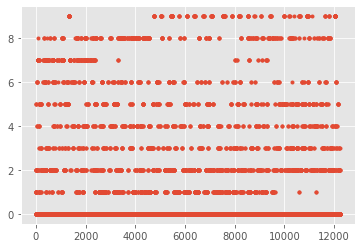

In [66]:
# Fitting K-Means to the dataset

X=X1

kmeans = KMeans(n_clusters = 10, init = 'k-means++')
y_kmeans = kmeans.fit_predict(X)
plt.plot(y_kmeans, ".")
plt.show()

In [67]:
def print_cluster(i):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print

**Output**
* Recommendation of product based on the current product selected by user.
* To recommend related product based on, Frequently bought together.

Top words in each cluster based on product description

In [68]:
# # Optimal clusters is 

true_k = 10

model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X1)

print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print_cluster(i)

Top terms per cluster:
Cluster 0:
 day
 delivery
 deliver
 kindly
 30
 morning
 0742331031
 tomorrow
 00
 00a
Cluster 1:
 00am
 urgently
 morning
 deliver
 10
 30
 kindly
 11
 tomorrow
 zero
Cluster 2:
 00a
 tomorrow
 morning
 deliver
 tommorrow
 latest
 30
 urgently
 possible
 0792588844
Cluster 3:
 early
 6am
 deliver
 kindly
 latest
 00am
 chicken
 chips
 churned
 coca
Cluster 4:
 6am
 deliver
 kindly
 0724232658
 strictly
 option
 emergency
 earlier
 delicer
 cola
Cluster 5:
 deliver
 time
 morning
 zero
 contact
 chicken
 chips
 churned
 coca
 coke
Cluster 6:
 30a
 tomorrow
 morning
 deliver
 urgently
 needed
 tommorrow
 monday
 delivery
 contact
Cluster 7:
 7am
 deliver
 kindly
 early
 latest
 delivery
 possible
 try
 6am
 bananas
Cluster 8:
 delivery
 00am
 morning
 urgent
 10
 30
 delivered
 churned
 coca
 coke
Cluster 9:
 30am
 urgently
 deliver
 morning
 early
 delivery
 kindly
 urgent
 10
 churned


C:\Users\HP\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Predicting clusters based on key search words

In [69]:
def show_recommendations(product):
    #print("Cluster ID:")
    Y = vectorizer.transform([product])
    prediction = model.predict(Y)
    #print(prediction)
    print_cluster(prediction[0])

**keyword** - early meal

In [77]:
show_recommendations("early meal")

Cluster 3:
 early
 6am
 deliver
 kindly
 latest
 00am
 chicken
 chips
 churned
 coca


Once a cluster is identified based on the user's search words, the recommendation system can display items from the corresponding product clusters based on the product descriptions.

**Summary:**


This works best if a business is setting up its e-commerce website for the first time and does not have user-item purchase/rating history to start with initally. This recommendation system will help the users get a good recommendation to start with and once the buyers have a purchased history, the recommendation engine can use the model based collaborative filtering technique.